In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import math
from pathlib import Path
import os
import tempfile
import shutil
from collections import defaultdict
import random
from PIL import ImageFont, ImageDraw, Image

import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


import config
from models import note_detector, double_tsek_detector

In [132]:
def remove_old_maker(image, position):
    ih, iw, _ = image.shape
    x, y, w, h = position
    patch_start_x = iw // 2
    patch = image[0:h, patch_start_x:patch_start_x+w]
    image[y:y+h, x:x+w] = patch
    return image

def insert_text(image, text, position, font_size):
    x, y = position
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)
    font = ImageFont.truetype("/Library/Fonts/Supplemental/Arial Unicode.ttf", font_size)
    draw = ImageDraw.Draw(pil_image)
    draw.text((x, y), text, font=font, fill=(65,65,65,255))
    image = np.asarray(pil_image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def alter_note_markers(image, matches):
    radius = int(0.0062 * image.shape[1])
    for x, y, w, h in matches:
        image = remove_old_maker(image, (x, y, w, h))
        x_center = (2*x+w) // 2
        y_center = (2*y+h) // 2
        # insert black circle covering the note maker
        cv2.circle(image, (x_center, y_center), radius, (65, 66, 65), -1)
    return image


def alter_double_tseks(image, matches):
    x_adjust = 0.0139 * image.shape[1]
    font_size = 0.0278 * image.shape[1]
    for x, y, w, h in matches:
        image = remove_old_maker(image, (x, y, w, h))
        image = insert_text(image, "【", (x-x_adjust, y), font_size)
    return image

def transform_image(input_image_fn:Path, output_image_fn:Path, imshow=False, verbose=False):
    image = cv2.imread(str(input_image_fn))

    note_matches = list(note_detector.predict(input_image_fn))
    double_tsek_matches = list(double_tsek_detector.predict(input_image_fn))

    if verbose:
        print("Image size:", image.shape)
        print("Notes count:", len(note_matches))
        print("Double Tsek count:", len(double_tsek_matches))
   
    if imshow:
        image_copy = image.copy()
        for x, y, w, h in note_matches:
            cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        for x, y, w, h in double_tsek_matches:
            cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)
        plt.figure(figsize=(20, 15), dpi=100)
        plt.imshow(image_copy)
        plt.show()

    
    image = alter_note_markers(image, note_matches)
    image = alter_double_tseks(image, double_tsek_matches)
    
    if imshow:
        plt.figure(figsize=(20, 15), dpi=100)
        plt.imshow(image)
        plt.show()

    cv2.imwrite(str(output_image_fn), image)

In [133]:
80 / 2869, 40 / 2869

(0.027884280237016383, 0.013942140118508192)

Image size: (4063, 2869, 3)
Notes count: 26
Double Tsek count: 13


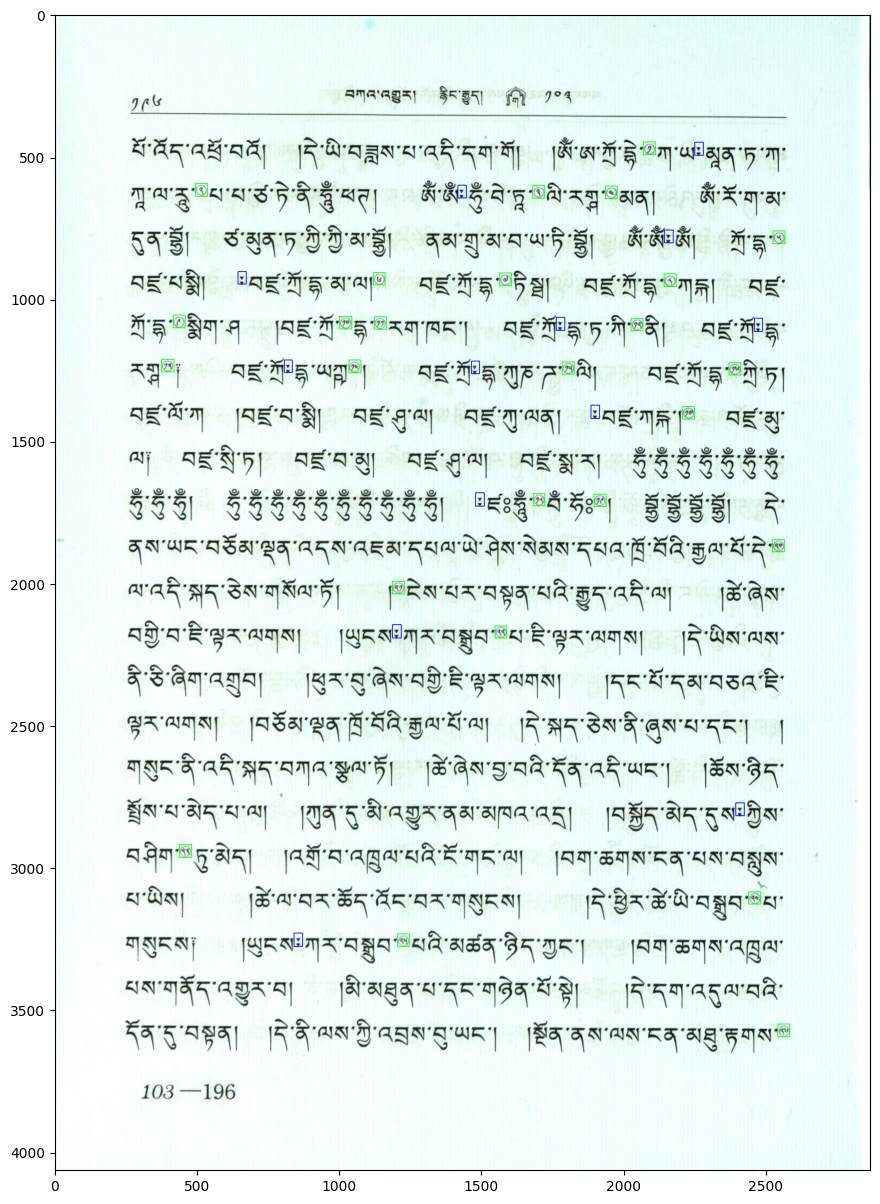

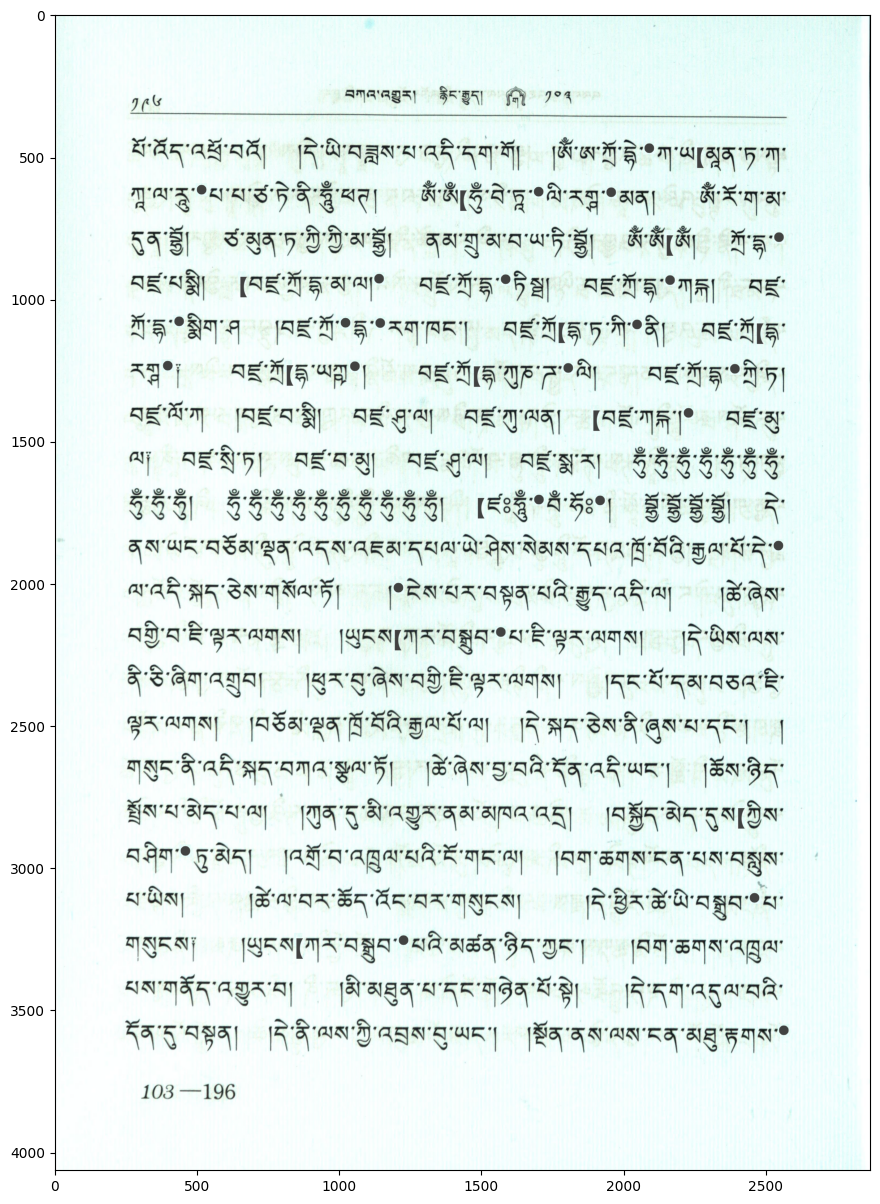

In [134]:
image_fn = config.IMAGES_PATH / "W1PD96682" / "W1PD96682-I1PD96886" / "text_pages" / "I1PD968860220.jpg"
output_fn = Path("test") / f"altered_{image_fn.name}"
transform_image(image_fn, output_fn, imshow=True, verbose=True)

Image size: (1957, 1347, 3)
Notes count: 9
Double Tsek count: 5


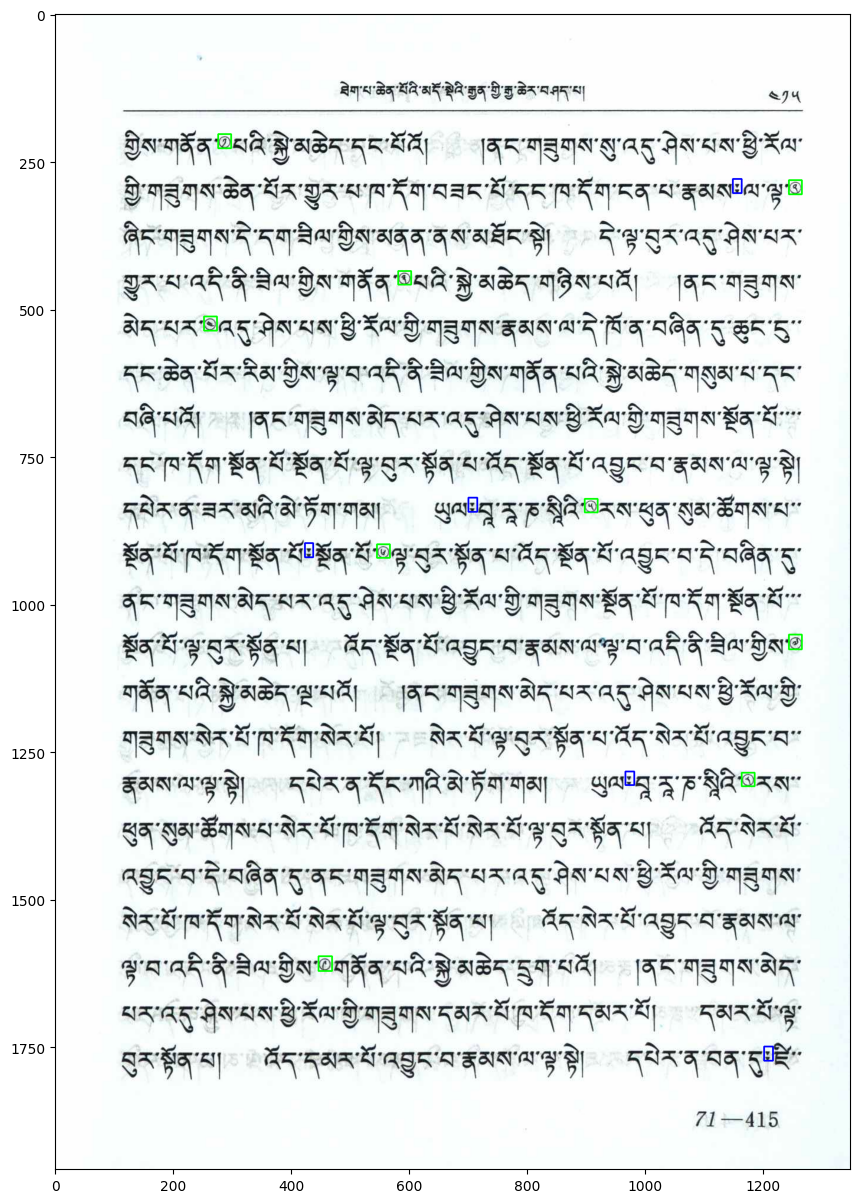

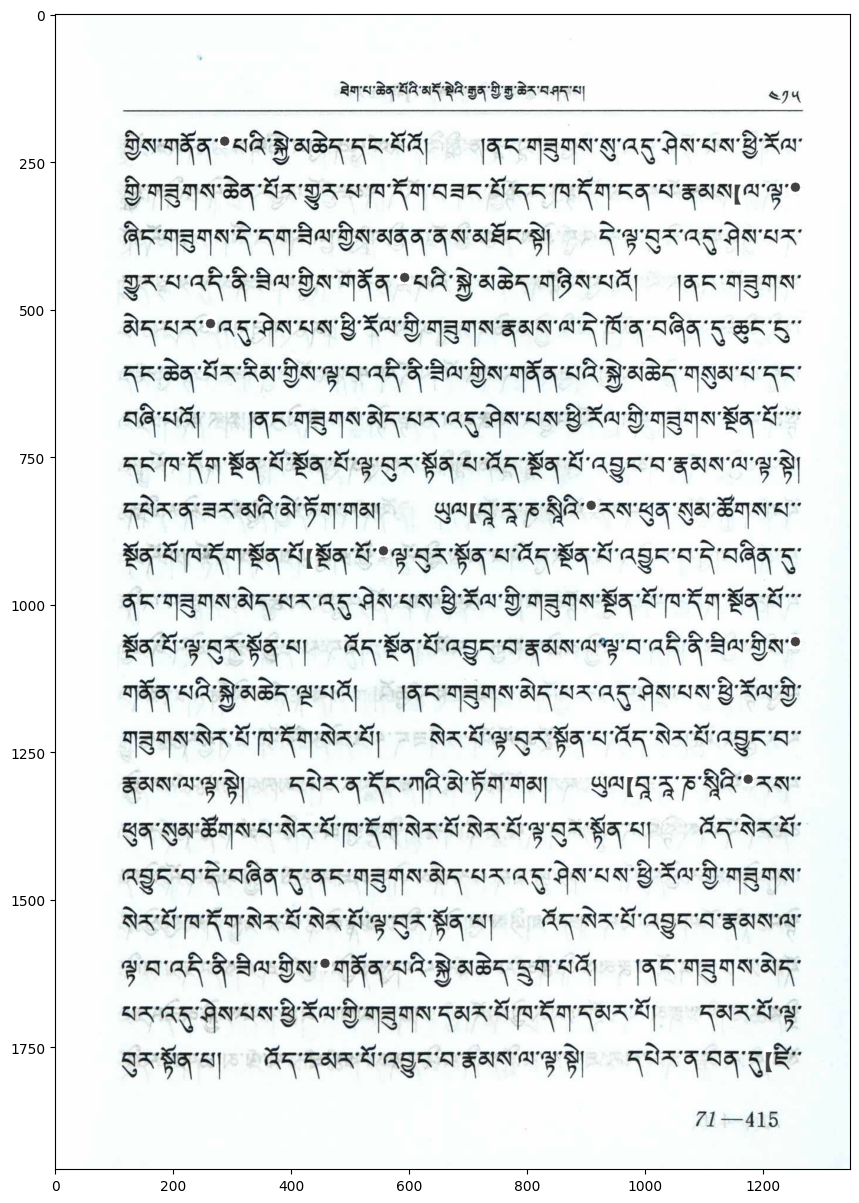

In [135]:
image_fn = Path("input/W1PD95844-I1PD95916/images/I1PD959160432.jpg")
output_fn = Path("test") / f"altered_{image_fn.name}"
transform_image(image_fn, output_fn, imshow=True, verbose=True)

In [159]:
def transform_volume(vol_path, output_dir):
    images_path = vol_path / "images"
    for image_fn in (pbar := tqdm(list(images_path.iterdir()))):
        if not image_fn.name.endswith(".jpg"): continue
        pbar.set_description(vol_path.name)
        output_fn = output_dir / image_fn.name
        if output_fn.is_file(): continue
        transform_image(image_fn, output_fn)

In [160]:
def run():
    for vol_path in tqdm(list(config.INPUT_PATH.iterdir())):
        output_dir = config.IMAGES_OUTPUT_PATH / vol_path.name
        output_dir.mkdir(parents=True, exist_ok=True)
        transform_volume(vol_path, output_dir)

In [161]:
run()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1683 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

## OCR

In [9]:
import io
import json

from google.cloud import vision
from google.cloud.vision import AnnotateImageResponse

In [10]:
vision_client = vision.ImageAnnotatorClient()

In [11]:
def google_ocr(image_fn, lang_hint=None):
    with io.open(image_fn, "rb") as image_file:
        content = image_file.read()
    ocr_image = vision.Image(content=content)
    features = [
        {
            "type_": vision.Feature.Type.DOCUMENT_TEXT_DETECTION,
            "model": "builtin/weekly",
        }
    ]
    image_context = {}
    if lang_hint:
        image_context["language_hints"] = [lang_hint]

    response = vision_client.annotate_image(
        {"image": ocr_image, "features": features, "image_context": image_context}
    )
    response_json = AnnotateImageResponse.to_json(response)
    response = json.loads(response_json)
    return response

In [12]:
image_fn = "output/images/W1PD95844-I1PD95916/I1PD959160092.jpg"
result = google_ocr(image_fn)

In [19]:
text = result["textAnnotations"][0]["description"]
print(text)

ཆོས་དང་ཆོས་ཉིད་རྣམ་པར་འབྱེད་པའི་འགྲེལ་པ།
D4
པར་བྱ་བའོ། །དེ་ཉིད་ཀྱི་ཕྱིར་ན་ཀུན་ནས་ཉོན་མོངས་པའི་རྒྱུ་ཡང་ཡིན་ཏེ། དེ་ལ་
མངོན་པར་ཞེན་པས་ནི་ཕྱི་མ་ལ་ཀུན་ནས་ཉོན་མོངས་པ་རྣམ་པ་གསུམ་འབྱུང་བའི་
ཕྱིར་རོ། །མེད་པ་སྣང་བ་ཡང་ཇི་ལྟ་བུ་ཞེ་ན། གསུངས་པ། སྒྱུ་མའི་གླང་པོ་ཆེ་ལ་
སོགས་པ་སྣང་བ་བཞིན་ནོ། །དཔེར་ན་སྒྱུ་མར་བྱས་པའི་གླང་པོ་ཆེ་ལ་སོགས་པ་་
དང་། ནོར་དང་འབྲུ་ལ་སོགས་པ་ནི་ཇི་ལྟར་སྣང་བ་དེ་ལྟར་མེད་ལ། སྣང་བ་ཡང་
ཡིན་པ་ལ་"དེ་བཞིན་དུ་ཡང་དག་པ་མ་ཡིན་པའི་ཀུན་ཏུ་རྟོག་པ་ཡང་མེད་•བཞིན་
དུ་སྣང་བ་ཡིན་ནོ། །གཞན་ཡང་•ཡོད་པ་ཡང་མི་སྣང་བའི་ཕྱིར་རོ། །འཁྲུལ་པ་་་་
ཞེས་རྗེས་སུ་འཇུག་གོ་•ཞེས་བྱ་བ་ནི་བདག་མེད་པ་རྣམ་པ་གཉིས་ཡོད་པ་མི་སྣང་
བའི་ཕྱིར་ཡང་འཁྲུལ་པ་ཡིན་ནོ། །མཐོ་•ཡོར་དང་མིའི་རྣམ་པ་ཡོད་པ་དང་མེད་་
པ་དག་མི་སྣང་བ【དང་སྣང་བ་●གང་ཡིན་པ་དེ་ནི་འཁྲུལ་པའི་མཚན་ཉིད་དོ་ཞེས་
དེ་ལྟར་འཇིག་རྟེན་ན་•མཐོང་བའི་ཕྱིར་རོ། །ཡང་ཅིའི་དོན་གྱིས་མེད་པ་དང་།
སྣང་བ་དག་ལས་གང་རུང་ཞིག་མེད་པར་མི་འདོད་ཅེ་ན། གསུངས་པ། མེད་
པ་དང་སྣང་བ་དག་ལས་གང་རུང་ཞིག་མེད་ན་ནི་འཁྲུལ་པ་དང་། [མ་འཁྲུལ་པ་་
དང་། ཀུན་ནས་ཉོན་མོངས་པ་དང་རྣམ་པར་བྱང་བ་མི་འཐད་དོ། །གལ་ཏེ་་
མེད་པ་ཁོ་ནར་གྱུར་ཏེ་སྣང་བར་མ་གྱུར

In [31]:
def ocr_volume(vol_path, output_dir):
    for image_fn in (pbar := tqdm(list(vol_path.iterdir()))):
        if not image_fn.name.endswith(".jpg"): continue
        pbar.set_description(vol_path.name)
        output_fn = output_dir / f"{image_fn.stem}.txt"
        if output_fn.is_file(): continue
        result = google_ocr(image_fn)
        try:
            text = result["textAnnotations"][0]["description"]
        except:
            continue
        output_fn.write_text(text)

In [34]:
def run_ocr():
    for vol_path in tqdm(list(config.IMAGES_OUTPUT_PATH.iterdir())):
        output_dir = config.OCR_OUTPUT_PATH / vol_path.name
        output_dir.mkdir(parents=True, exist_ok=True)
        ocr_volume(vol_path, output_dir)

In [35]:
run_ocr()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]